In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt
import os
import re
import pandas as pd
from collections import defaultdict
import matplotlib.colors as mcolors


# --- COLOR SPACE UTILITIES ---
def hex_to_rgb(hex_color):
    return [int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)]

def f(t):
    delta = 6/29
    return np.where(t > delta**3, np.cbrt(t), (t / (3 * delta**2)) + (4/29))

def inv_f(t):
    delta = 6/29
    return np.where(t > delta, t**3, 3 * delta**2 * (t - 4/29))

def inv_gamma_correct(c):
    return np.where(c <= 0.0031308, 12.92 * c, 1.055 * np.power(c, 1/2.4) - 0.055)

def lab_normalize(lab):
    return (lab + np.array([0, 128, 128])) / np.array([100, 255, 255])

def lab_unnorm(lab):
    return lab * np.array([100, 255, 255]) - np.array([0, 128, 128])

def lab_to_rgb(lab):
    L, a, b = lab
    fy = (L + 16) / 116
    fx = fy + a / 500
    fz = fy - b / 200
    xyz = np.array([
        0.95047 * inv_f(fx),
        1.00000 * inv_f(fy),
        1.08883 * inv_f(fz)
    ])
    rgb_lin = np.array([
        3.2406 * xyz[0] - 1.5372 * xyz[1] - 0.4986 * xyz[2],
        -0.9689 * xyz[0] + 1.8758 * xyz[1] + 0.0415 * xyz[2],
        0.0557 * xyz[0] - 0.2040 * xyz[1] + 1.0570 * xyz[2]
    ])
    rgb = inv_gamma_correct(np.clip(rgb_lin, 0, 1))
    return np.clip(rgb, 0, 1)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def convert_lab(image):
    mask = image > 0.04045
    img_linear = np.where(mask, ((image + 0.055) / 1.055) ** 2.4, image / 12.92)
    R, G, B = img_linear[..., 0], img_linear[..., 1], img_linear[..., 2]
    X = (0.4124564 * R + 0.3575761 * G + 0.1804375 * B) / 0.950489
    Y = (0.2126729 * R + 0.7151522 * G + 0.0721750 * B) / 1.0
    Z = (0.0193339 * R + 0.1191920 * G + 0.9503041 * B) / 1.088840
    X, Y, Z = f(X), f(Y), f(Z)
    L = 116.0 * Y - 16.0
    a = 500.0 * (X - Y)
    b = 200.0 * (Y - Z)
    return np.stack([L, a, b], axis=-1)

def make_dataset():
    basedir = "Data/Res_ColorPickerCustomPicker"
    rows = []

    for file in os.listdir(basedir):
        filepath = os.path.join(basedir, file)
        if re.match(r".*\d{2}\.txt", file):
            image_groups = defaultdict(list)  # key: image filename, value: list of color groups

            with open(filepath, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    image = parts[0]
                    colors = [c.strip(",").replace('#', '') for c in parts[1:]]
                    image_groups[image].append(colors)

            # Now for each image in this file, pad its color groups and add to the rows
            for image, color_groups in image_groups.items():
                while len(color_groups) < 5:
                    color_groups.append([])

                rows.append({
                    'file': file,
                    'image': image,
                    'color_1': color_groups[0],
                    'color_2': color_groups[1],
                    'color_3': color_groups[2],
                    'color_4': color_groups[3],
                    'color_5': color_groups[4],
                })

    return pd.DataFrame(rows)



def hex_to_rgb_tuple(hex_color):
    return mcolors.to_rgb(hex_color)

2025-06-11 20:02:12.046393: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 20:02:12.049165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 20:02:12.056205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749664932.068222   41383 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749664932.071567   41383 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749664932.081476   41383 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
import numpy as np
# Test Lab conversion
rgb_color = np.array([0.5, 0.2, 0.8]) # Example RGB color
lab_color = convert_lab(rgb_color)
print(f"RGB: {rgb_color}")
print(f"Lab: {lab_color}")

# Convert back to RGB to check
rgb_back = lab_to_rgb(lab_color)
print(f"RGB back from Lab: {rgb_back}")

# Test normalization and unnormalization
normalized_lab = lab_normalize(lab_color)
print(f"Normalized Lab: {normalized_lab}")

unnormalized_lab = lab_unnorm(normalized_lab)
print(f"Unnormalized Lab: {unnormalized_lab}")

# Test with hex
hex_color = "ff0000" # Red
rgb_from_hex = hex_to_rgb(hex_color)
print(f"Hex: {hex_color}, RGB from hex: {rgb_from_hex}")

# Test hex to rgb tuple
rgb_tuple_from_hex = hex_to_rgb_tuple("#"+hex_color)
print(f"Hex: {hex_color}, RGB tuple from hex: {rgb_tuple_from_hex}")

# Test rgb to hex
hex_from_rgb = rgb_to_hex(rgb_from_hex)
print(f"RGB: {rgb_from_hex}, Hex from RGB: {hex_from_rgb}")

In [3]:
# --- DATA PREPARATION ---
# Load and process your dataframe
input_colors = 5

df = make_dataset()

print(df)
df['lab'] = df['color_5'].apply(
    lambda colors: [convert_lab(np.array(hex_to_rgb(c))) for c in colors]
)
basedir = "Data/PhotosColorPicker/"
#df_grouped['lab'] = df_grouped['target_rgb'].apply(convert_lab)
df['image_path'] = basedir + df['image']
print(df)

# Load image tensors
def load_image(path):
    img = load_img(path, target_size=(64, 64))
    rgb_norm = img_to_array(img) / 255.0
    lab = convert_lab(rgb_norm)
    return lab_normalize(lab)

image_tensors = tf.stack([load_image(path) for path in df['image_path']])
labs = np.stack(df['lab'].values)
labels = np.array(lab_normalize(labs).astype(np.float64)).reshape(-1, 3*input_colors)
#labels.shape = (n,9)
# TF dataset
dataset = tf.data.Dataset.from_tensor_slices((image_tensors, labels)).shuffle(buffer_size=len(image_tensors))
val_size = int(0.2 * len(image_tensors))
train_dataset = dataset.skip(val_size).batch(32)
val_dataset = dataset.take(val_size).batch(32)

                                        file             image   color_1  \
0               GKew_2025_03_20-11_03_35.txt  000000010432.jpg  [fff535]   
1               GKew_2025_03_20-11_03_35.txt  000000014824.jpg  [cc4053]   
2               GKew_2025_03_20-11_03_35.txt  000000022423.jpg  [a9a6b2]   
3               GKew_2025_03_20-11_03_35.txt  000000023019.jpg  [916899]   
4               GKew_2025_03_20-11_03_35.txt  000000029255.jpg  [acb5e5]   
...                                      ...               ...       ...   
1887  KolegaMichal23_2025_03_27-10_56_01.txt  000000537131.jpg  [bf3b0d]   
1888  KolegaMichal23_2025_03_27-10_56_01.txt  000000547938.jpg  [089303]   
1889  KolegaMichal23_2025_03_27-10_56_01.txt  000000556123.jpg  [79c173]   
1890  KolegaMichal23_2025_03_27-10_56_01.txt  000000562160.jpg  [ce4d32]   
1891  KolegaMichal23_2025_03_27-10_56_01.txt  000000572756.jpg  [cca6cb]   

               color_2                   color_3  \
0     [ffe93b, 32332f]  [fff344, 2f

In [22]:
# --- MODEL DEFINITION ---
# model = models.Sequential([
#     layers.Input(shape=(64, 64, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dense(3*input_colors, activation='sigmoid')
# ])

# model = models.Sequential([
#     layers.Input(shape=(64, 64, 3)),
#     layers.Conv2D(32, (7, 7), activation='relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(4, 4),
#     layers.Flatten(),
#     layers.Dense(3*256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(3*input_colors, activation='sigmoid')  # Predict L, a, b
# ])

model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(64 * input_colors, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128 * input_colors, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256 * input_colors, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(3 * input_colors, activation='sigmoid')
])

#!

model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True, learning_rate=1e-3), loss='mse')
model.fit(train_dataset, epochs=15, validation_data=val_dataset)



Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 0.0556 - val_loss: 0.0358
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss: 0.0357 - val_loss: 0.0362
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0347 - val_loss: 0.0343
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0346 - val_loss: 0.0337
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0336 - val_loss: 0.0319
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.0338 - val_loss: 0.0320
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.0332 - val_loss: 0.0327
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0326 - val_loss: 0.0329
Epoch 9/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - loss: 0.0338 - val_loss: 0.0327
Epoch 10/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 0.0335 - val_loss: 0.0319
Epoch 11/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 0.0327 - val_loss: 0.0326
Epoch 12/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - loss: 0.0324 - val_lo

In [23]:
# --- EVALUATION ---
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

def mae(predictions, truth):
    return np.mean(np.abs(predictions - truth))

def rmse(predictions, truth):
    return np.sqrt(np.mean((predictions - truth)**2))

def safe_compare(predictions, truth):
    eps = 1e-6
    return np.mean(np.abs(predictions - truth) / (np.abs(truth) + eps), axis=0)

all_preds = model.predict(tf.data.Dataset.from_tensor_slices(image_tensors).batch(32))
val_predicts = model.predict(val_dataset)
print("Compare %:", safe_compare(val_predicts, labels[:len(val_predicts)]) * 100)
print("MAE:", mae(val_predicts, labels[:len(val_predicts)]))
print("RMSE:", rmse(val_predicts, labels[:len(val_predicts)]))


for i in range(5):
    p = (((val_predicts[i])))
    t = ((labels[i]))
    print("Predicted:", rgb_to_hex(p), "True:", rgb_to_hex(t))
# --- PREDICTION VISUALIZATION ---
def show_colors(hex_list, titles=None):
    fig, ax = plt.subplots(1, len(hex_list), figsize=(len(hex_list) * 2, 2))
    if len(hex_list) == 1:
        ax = [ax]
    for i, hex_color in enumerate(hex_list):
        rgb = np.array([[hex_to_rgb_tuple(hex_color)]])
        ax[i].imshow(rgb)
        ax[i].axis("off")
        if titles:
            ax[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step
Compare %: [2.07854055e+06 3.23103866e+01 4.74546055e+01 1.30673669e+06
 2.58970521e+01 3.47525637e+01 3.04064592e+06 1.81265947e+01
 2.64092414e+01 3.08236764e+06 1.69896468e+01 2.28566702e+01
 3.12652937e+06 1.51698167e+01 2.09274526e+01]
MAE: 0.1564216353841454
RMSE: 0.20812069406868142
Predicted: #a55bae True: #e17dc8
Predicted: #9f7982 True: #82c499
Predicted: #98bab0 True: #9e807e
Predicted: #a66b9d True: #9a9f5f
Predicted: #9c8a8a True: #cb8f61


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted color: ['#a6ab68', '#9b9950', '#998462', '#969f7c', '#a5886f']
True color: ['#000000', '#b5e567', '#e59846', '#dae5e2', '#99263a']


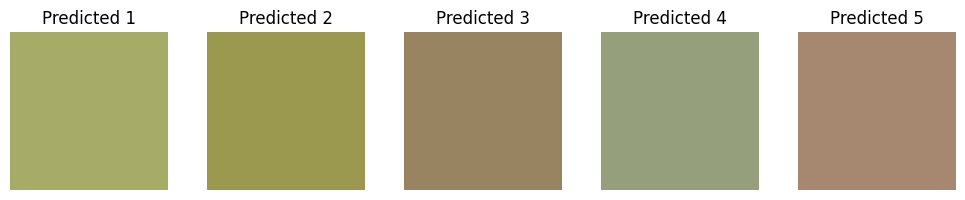

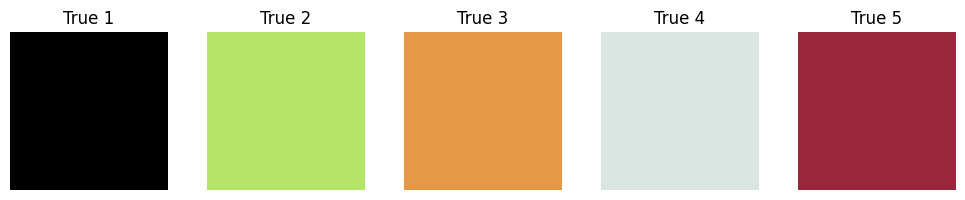

In [32]:
# Predict on new image

#model = keras.saving.load_model("model.keras")

file = "000000348684.jpg"
image_path = f"Data/PhotosColorPicker/{file}"
image = load_img(image_path, target_size=(64, 64))
img_array = img_to_array(image) / 255.0
lab_image = convert_lab(img_array)
lab_normed = lab_normalize(lab_image)
input_arr = np.expand_dims(lab_normed, axis=0)
prediction = model.predict(input_arr).reshape(input_colors,3)
lab_pred = [lab_unnorm(i) for i in prediction]
rgb_pred = [lab_to_rgb(i) for i in lab_pred]
pred_hex = [rgb_to_hex(i) for i in rgb_pred]

true_rgb = [lab_to_rgb(i) for i in df[df['image'] == file]["lab"].values[0]]
true_hex = [rgb_to_hex(i) for i in true_rgb]
print("Predicted color:", pred_hex)
print("True color:", true_hex)
titles = [f"Predicted {i+1}" for i in range(len(pred_hex))]
show_colors(pred_hex, titles)
titles = [f"True {i+1}" for i in range(len(true_hex))]
show_colors(true_hex, titles)

In [35]:
model.save("model.keras")